In [1]:
import jax
import jax.numpy as np

from numpy.polynomial.hermite import hermgauss

from structure_vb_lib import structure_model_lib, posterior_quantities_lib, data_utils, plotting_utils
from structure_vb_lib.structure_optimization_lib import optimize_structure

from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(5345)

# Load data

In [3]:
g_obs, _, labels, _ = data_utils.load_thrush_data()

In [4]:
print(g_obs.shape)

(155, 7, 2, 21)


In [5]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_allele = g_obs.shape[-1]

In [6]:
onp.unique(labels)

array(['Chawia', 'Mbololo', 'Ngangao', 'Yale'], dtype='<U32')

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params(n_allele)

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': DeviceArray([6.], dtype=float64), 'allele_prior_lambda_vec': DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1.], dtype=float64)}


# Get VB params 

In [8]:
k_approx = 20

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs = n_obs,
                                                      n_loci = n_loci,
                                                      n_allele = n_allele, 
                                                      k_approx = k_approx)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_dirichlet_params] = NumericArrayPattern (20, 7, 21) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (155, 19) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (155, 19) (lb=0.0, ub=inf)


# Optimize

In [12]:
vb_opt_dict, vb_opt, ez_opt, out, _ = \
    optimize_structure(g_obs,
                      vb_params_dict,
                      vb_params_paragami,
                      prior_params_dict, 
                      gh_loc, 
                      gh_weights)

compiling objective and derivatives ... 
done. Compile time: 45.212sec
Running L-BFGS-B ...
L-BFGS-B time: 3.884sec
BFGS out:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Running trust-ncg ... 
Newton time: 3.453sec
Newton out:  Optimization terminated successfully.
done. 


# Check out the fit

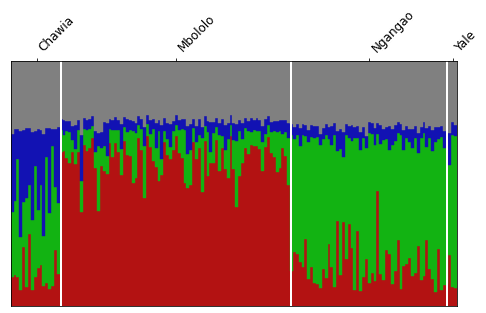

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (8, 4.5))

e_ind_admix = posterior_quantities_lib.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

plotting_utils.plot_top_clusters(onp.array(e_ind_admix), ax, 3);
plotting_utils.draw_region_separation(labels, ax);

# Define sensitivity object

In [12]:
# initial prior alpha
use_free_alpha = True
prior_alpha0 = prior_params_paragami['dp_prior_alpha'].flatten(prior_params_dict['dp_prior_alpha'], 
                                                              free = use_free_alpha)

In [13]:
# set up objective as function of vb params and prior param 

_hyper_par_objective_fun = lambda vb_params, prior_params : \
    structure_model_lib.alpha_objective_fun(vb_params, 
                                            prior_params, 
                                            gh_loc, 
                                            gh_weights)
    
hyper_par_objective_fun = paragami.FlattenFunctionInput(
                                original_fun=_hyper_par_objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])

### Set up hessian solver

In [14]:
# define preconditioner
cg_precond = lambda v : get_mfvb_cov_matmul(v, vb_opt_dict,
                                            vb_params_paragami,
                                            return_info = True)

In [15]:
vb_sens = HyperparameterSensitivityLinearApproximation(
                    # `objective_fun` doesnt matter bc we give it the hvp
                    # and the `hyper_par_objective_fun`
                    objective_fun = None,
                    opt_par_value = vb_opt, 
                    hyper_par_value0 = prior_alpha0, 
                    obj_fun_hvp = precond_objective.hvp, 
                    hyper_par_objective_fun = hyper_par_objective_fun, 
                    cg_precond = cg_precond)

NOTE: using custom hvp
Compiling hessian solver ...
Hessian solver compile time: 100.226sec

Compiling cross hessian...
Cross-hessian compile time: 0.274566sec

LR sensitivity time: 0.474952sec



# Perturb alpha. Check results

In [16]:
# set new alpha 
new_alpha = prior_params_dict['dp_prior_alpha'] + 0.1 

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['dp_prior_alpha'] = new_alpha


In [17]:
print('initial alpha, ', prior_params_dict['dp_prior_alpha'])
print('perturbed alpha, ', prior_params_pert_dict['dp_prior_alpha'])


initial alpha,  [3.]
perturbed alpha,  [3.1]


In [18]:
# linear response prediction 
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha))

print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))


l_inf diff:  0.0590591079520264


In [19]:
(lr_vb_free_params**2).mean()

DeviceArray(2.39985977, dtype=float64)

### reoptimize

In [20]:
new_init_dict = deepcopy(vb_opt_dict)

In [21]:
vb_pert_dict, vb_opt_pert = \
    s_optim_lib.run_preconditioned_lbfgs(g_obs, 
                        new_init_dict, 
                        vb_params_paragami,
                        prior_params_pert_dict,
                        gh_loc, gh_weights)[0:2]

compiling preconditioned objective ... 
done. Elasped: 25.7284
init kl: 13243.006250
iteration [14]; kl:13242.691131; elapsed: 1.201secs
lbfgs converged successfully
done. Elapsed 1.7726


### compare

In [22]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


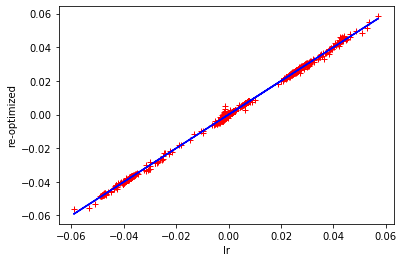

In [23]:
# compare free parameters
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [24]:
key = jax.random.PRNGKey(1)

def get_e_num_pred_clusters(vb_params_dict): 
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, 
                                                       stick_infos, 
                                                       gh_loc,
                                                       gh_weights, 
                                                       key = key,
                                                       n_samples = 100)

In [25]:
print('init number of cluster: ', get_e_num_pred_clusters(vb_opt_dict))
print('pert number of cluster: ', get_e_num_pred_clusters(vb_pert_dict))
print('lr number of cluster: ', get_e_num_pred_clusters(vb_params_paragami.fold(lr_vb_free_params, 
                                                                                free = True)))

init number of cluster:  3.5935626701199976
pert number of cluster:  3.62118375297087
lr number of cluster:  3.621202441727375


# Fit for a range of alpha

In [26]:
alpha_list = np.arange(1, 10)

In [27]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # set new objective 
    vb_opt_pert = \
        s_optim_lib.run_preconditioned_lbfgs(g_obs, 
                        new_init_dict, 
                        vb_params_paragami,
                        prior_params_pert_dict,
                        gh_loc, gh_weights)[1]
        
    return vb_opt_pert


In [28]:
print('alphas: ', alpha_list)

alphas:  [1 2 3 4 5 6 7 8 9]


TODO: refactor the optimizer so it doesnt need to recompile every time ...

In [29]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\n re-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, new_init_dict))



 re-optimzing with alpha =  1
compiling preconditioned objective ... 
done. Elasped: 25.4043
init kl: 12563.415506
iteration [20]; kl:12351.868800; elapsed: 1.829secs
iteration [31]; kl:12351.787488; elapsed: 1.029secs
lbfgs converged successfully
done. Elapsed 3.4515

 re-optimzing with alpha =  2
compiling preconditioned objective ... 
done. Elasped: 25.2005
init kl: 12887.030146
iteration [20]; kl:12848.087598; elapsed: 1.606secs
iteration [29]; kl:12848.085668; elapsed: 0.808secs
lbfgs converged successfully
done. Elapsed 2.9954

 re-optimzing with alpha =  3
compiling preconditioned objective ... 
done. Elasped: 25.4411
init kl: 13210.644786
iteration [2]; kl:13210.644709; elapsed: 0.317secs
lbfgs converged successfully
done. Elapsed 0.8878

 re-optimzing with alpha =  4
compiling preconditioned objective ... 
done. Elasped: 25.4611
init kl: 13534.259426
iteration [20]; kl:13506.439432; elapsed: 1.561secs
iteration [21]; kl:13506.439406; elapsed: 0.233secs
lbfgs converged success

# Check free parameters

In [30]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha)))


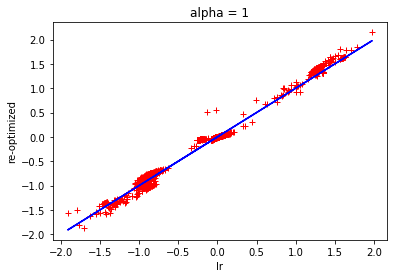

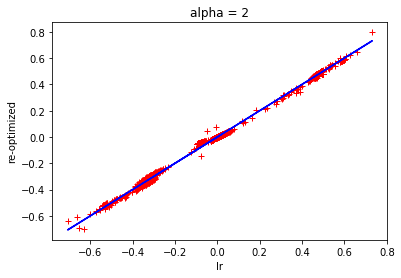

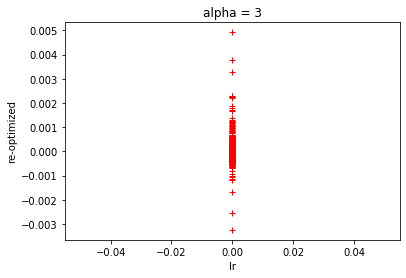

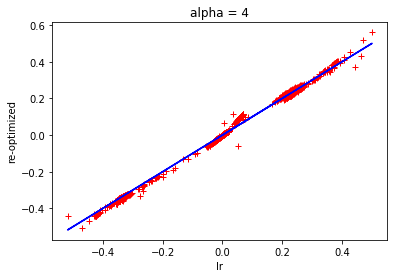

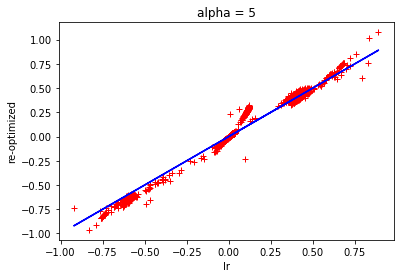

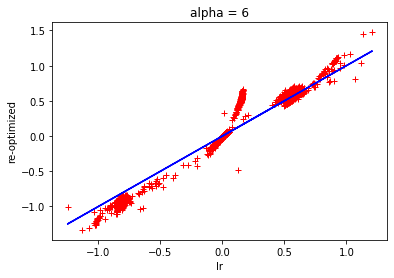

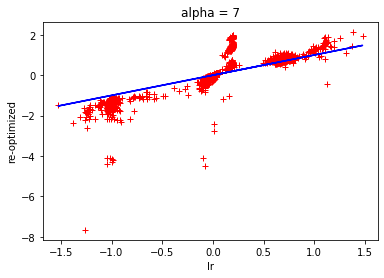

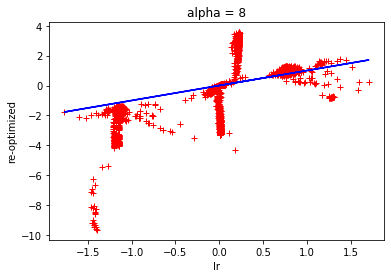

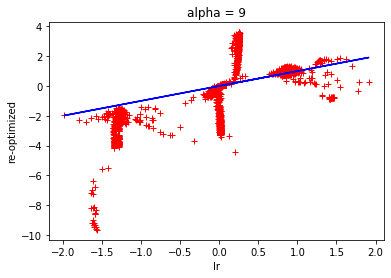

In [31]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))


# Number of clusters

In [32]:
import numpy as onp

In [33]:
lr_e_num_clusters_vec = onp.zeros(len(alpha_list))
refit_e_num_clusters_vec = onp.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    
    # get dictionaries
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
        
    # get number of clusters
    refit_e_num_clusters_vec[i] = get_e_num_pred_clusters(pert_dict)
    lr_e_num_clusters_vec[i] = get_e_num_pred_clusters(lr_dict)


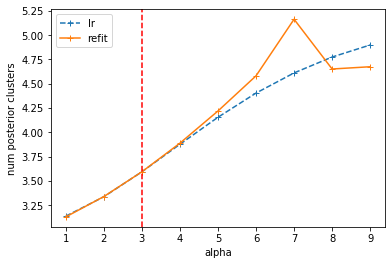

In [34]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['dp_prior_alpha'], color = 'red', linestyle = 'dashed')